# Walmart - Store Sales Forecasting
- Contributor: Vamshidhar Reddy Parupally - 016001427
- 255 Data Mining Final Project

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())

In [2]:
features = pd.read_csv('https://raw.githubusercontent.com/vamshidhar199/255Project/main/features.csv')
train = pd.read_csv('https://raw.githubusercontent.com/vamshidhar199/255Project/main/train.csv')
stores = pd.read_csv('https://raw.githubusercontent.com/vamshidhar199/255Project/main/stores.csv')
test = pd.read_csv('https://raw.githubusercontent.com/vamshidhar199/255Project/main/test.csv')

In [3]:
sample_submission = pd.read_csv('https://raw.githubusercontent.com/vamshidhar199/255Project/main/sampleSubmission.csv')

# Exploratory data analysis

* Here we have different csv files, which we have to combine as one in order to make data more comprehensive and to make the process of understanding data and training model simpler and easier.

* Starting with the data in features, train, stores and test.


In [4]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
features.shape
#features.columns

(8190, 12)

* Features dataset contains about 12 features 
      [Store', 'Date', 'Temperature',   'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'].
* The shape is 8190 by 12

In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
train.shape

(421570, 5)

* Train contains details about store, department, date weekly sales and is holiday.

In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
stores.shape


(45, 3)

In [10]:
test.tail()

,Store,Dept,Date,IsHoliday
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


In [11]:
test.shape

(115064, 4)

---
Now we have to merge these based on the common field store

In [12]:
feature_store = features.merge(stores, how='inner', on='Store')

In [13]:
feature_store.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [14]:
pd.DataFrame(feature_store.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


* feature_store is the inner join of the feature and store, which contains float64, bool, object and int64 data types

In [15]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [16]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [17]:
test.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [18]:
feature_store.Date = pd.to_datetime(feature_store.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

* If we notice the data we find that the date is essentially every friday , and the data is for every friday. So it is ideal to consider the week and the year fields of the date instead of entire date.

In [19]:
feature_store['Week'] = feature_store.Date.dt.week 
feature_store['Year'] = feature_store.Date.dt.year

In [20]:
train_detail = train.merge(feature_store, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [21]:
train_detail_rnn=train_detail

In [22]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010


In [23]:
test_detail = test.merge(feature_store, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [24]:
test_detail.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,2012
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,45,2012
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,46,2012
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,47,2012
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,48,2012


## Null values
Now letsdive into null values

In [25]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index

In [26]:
null_columns

Index(['MarkDown2', 'MarkDown4', 'MarkDown3', 'MarkDown1', 'MarkDown5', 'Week',
       'Size', 'Type', 'Unemployment', 'CPI', 'Store', 'Dept', 'Fuel_Price',
       'Temperature', 'IsHoliday', 'Weekly_Sales', 'Date', 'Year'],
      dtype='object')

In [27]:
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data

,0,1,2
Store,0,0.000000,int64
Dept,0,0.000000,int64
Date,0,0.000000,datetime64[ns]
Weekly_Sales,0,0.000000,float64
IsHoliday,0,0.000000,bool
Temperature,0,0.000000,float64
Fuel_Price,0,0.000000,float64
MarkDown1,270889,0.642572,float64
MarkDown2,310322,0.736110,float64
MarkDown3,284479,0.674808,float64


In [28]:
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data


,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


This is important, there are columns with more than 60% of null values. If the correlations of these features with the target 'WeeklySales' are ~0, then it is not a good idea to use them. 

To find out how many days were available before a holiday, we are performing the below operation.

It is important to find out the number of days present before a holiday as it may result in increase of sales.



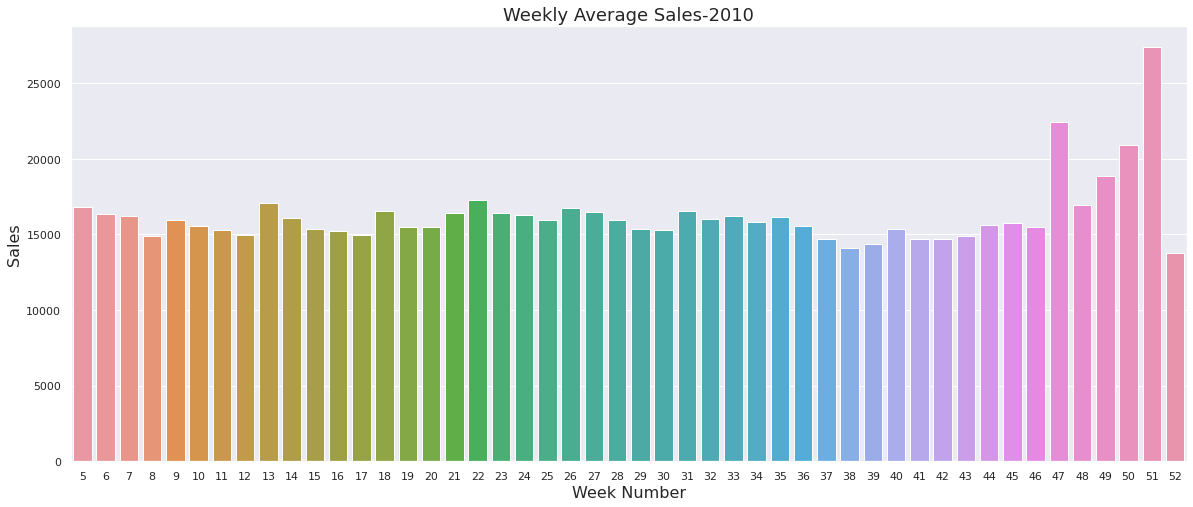

In [29]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()

plt.figure(figsize=(20,8))
sns.set_theme(style="darkgrid")
sns.barplot(weekly_sales_2010.index, weekly_sales_2010.values)

plt.title('Weekly Average Sales-2010', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week Number', fontsize=16)
plt.savefig('weeklySales2010.pdf')

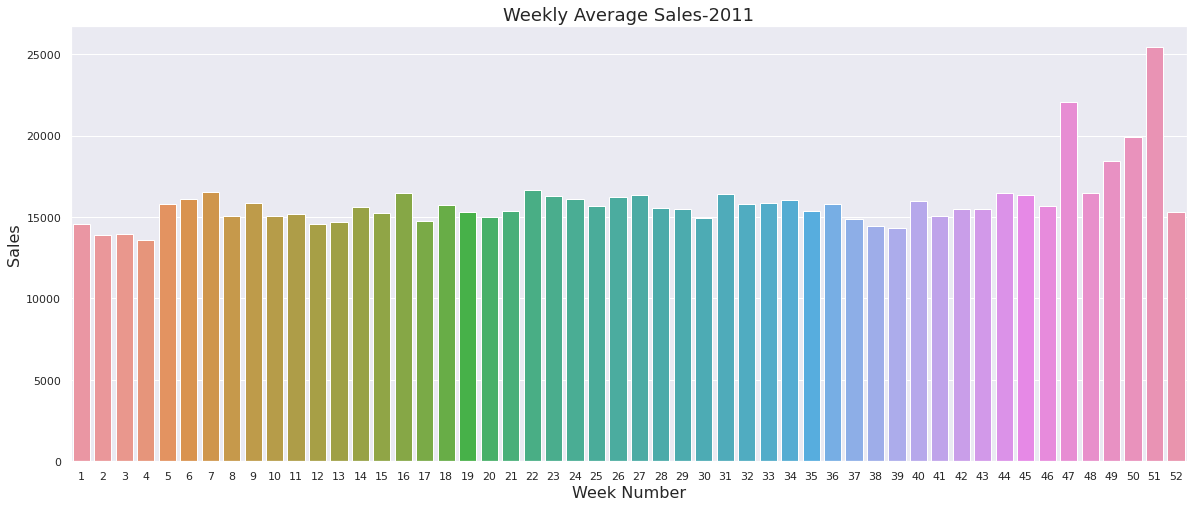

In [30]:
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()

plt.figure(figsize=(20,8))
sns.set_theme(style="darkgrid")
sns.barplot(weekly_sales_2011.index, weekly_sales_2011.values)
plt.title('Weekly Average Sales-2011', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week Number', fontsize=16)
plt.savefig('weeklySales2011.pdf')

In [31]:
#weekly_sales_2012

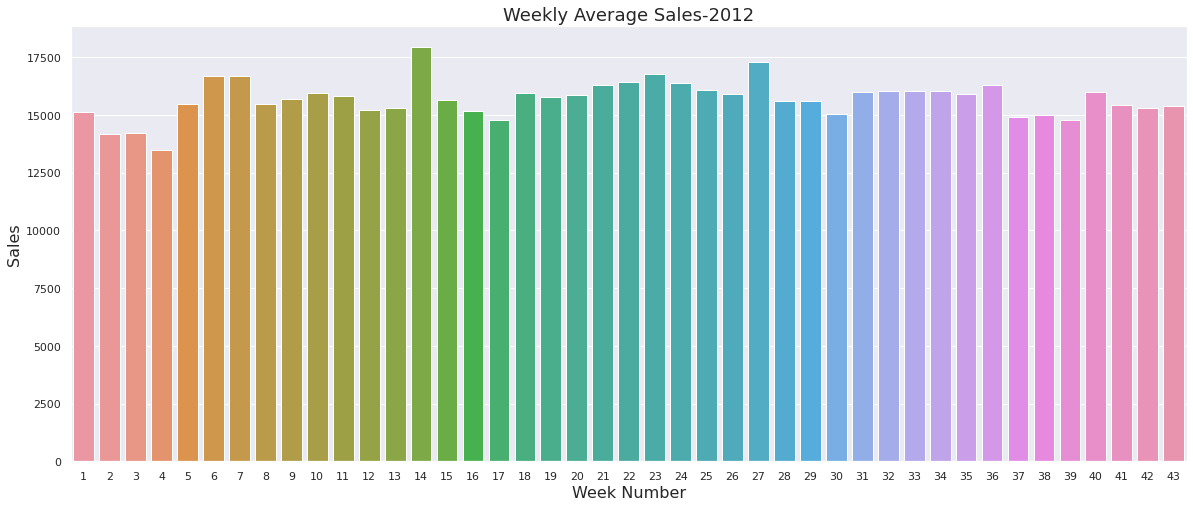

In [32]:
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()

plt.figure(figsize=(20,8))
sns.set_theme(style="darkgrid")
sns.barplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.title('Weekly Average Sales-2012', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week Number', fontsize=16)
plt.savefig('weeklySales2012.pdf')

As we analyse the graph we find that there are high sales in week 14 of 2012, week 13 of 2010 and week 16 of 2011, on analysing we can get the holiday as Easter day. So we can set this value to true as well.
In 2013 easter is on march 31 which is week 13.

In [33]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

## Correlation between variables

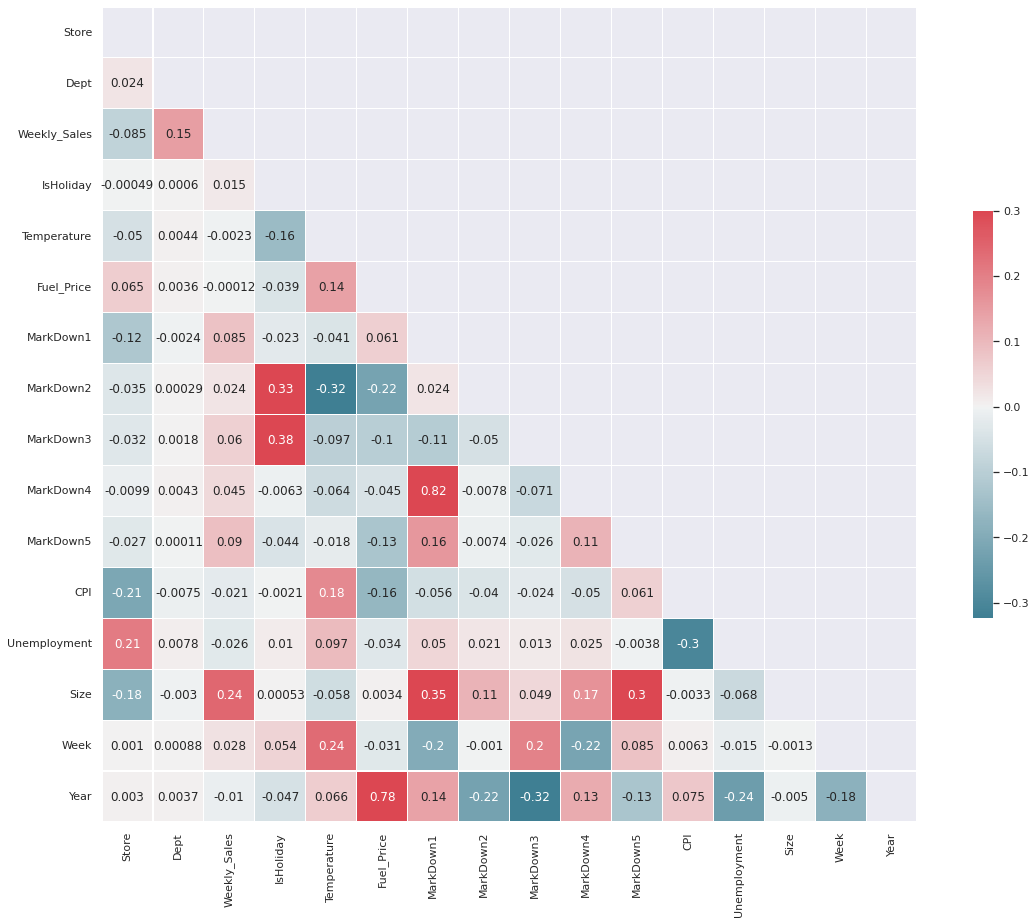

In [34]:


corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.savefig('correlation.pdf')

* Temperature, CPI, Unemployment, Temperature and fuel prices have negative corelation with weekly sales.
* Also markdowns are not strongly corelated and values and they have more null values , with all these factors we can simply drop them.

In [35]:
#droping markdown values
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

## Outlier Analysis

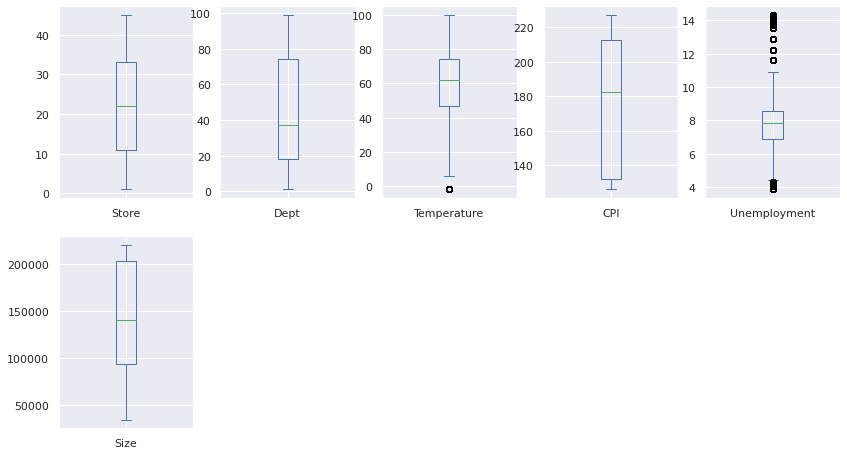

In [36]:
train_detail[['Store', 'Dept', 'IsHoliday', 'Temperature', 'CPI', 'Unemployment', 'Type', 'Size']].plot(kind='box',subplots=1,layout=(3,5),figsize=(14,12))
plt.savefig('boxplot.pdf')

In [37]:
train_detail.describe()

,Store,Dept,Weekly_Sales,Temperature,CPI,Unemployment,Size,Week,Year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,171.201947,7.960289,136727.915739,25.826762,2010.968591
std,12.785297,30.492054,22711.183519,18.447931,39.159276,1.863296,60980.583328,14.151887,0.796876
min,1.000000,1.000000,-4988.940000,-2.060000,126.064000,3.879000,34875.000000,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,46.680000,132.022667,6.891000,93638.000000,14.000000,2010.000000
50%,22.000000,37.000000,7612.030000,62.090000,182.318780,7.866000,140167.000000,26.000000,2011.000000
75%,33.000000,74.000000,20205.852500,74.280000,212.416993,8.572000,202505.000000,38.000000,2012.000000
max,45.000000,99.000000,693099.360000,100.140000,227.232807,14.313000,219622.000000,52.000000,2012.000000


In [38]:
#quantiles
uQ1 = train_detail['Unemployment'].quantile(0.25)
uQ3 = train_detail['Unemployment'].quantile(0.75)
IQR1 = uQ3 - uQ1
print(IQR1)

tQ1 = train_detail['Temperature'].quantile(0.25)
tQ3 = train_detail['Temperature'].quantile(0.75)
IQR2 = tQ3 - tQ1
print(IQR2)

1.6809999999999992
27.6


In [39]:
train_detail[(train_detail['Unemployment'] >= uQ1) & (train_detail['Unemployment'] <= uQ3)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
421548,45,98,2012-06-01,874.64,False,74.48,191.009171,8.567,B,118221,22,2012
421549,45,98,2012-06-08,713.50,False,64.30,191.015533,8.567,B,118221,23,2012
421550,45,98,2012-06-15,856.35,False,71.93,191.029973,8.567,B,118221,24,2012
421551,45,98,2012-06-22,622.62,False,74.22,191.064610,8.567,B,118221,25,2012


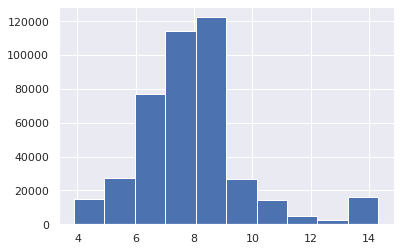

In [40]:
train_detail['Unemployment'].hist()


Although box plot shows there are outliers, but the amount of row (outliers) are significant we decide to proceed without removing those outliers.

In [41]:
train_detail[(train_detail['Temperature'] >= tQ1) & (train_detail['Temperature'] <= tQ3)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
5,1,1,2010-03-12,21043.39,False,57.79,211.380643,8.106,A,151315,10,2010
6,1,1,2010-03-19,22136.64,False,54.58,211.215635,8.106,A,151315,11,2010
7,1,1,2010-03-26,26229.21,False,51.45,211.018042,8.106,A,151315,12,2010
8,1,1,2010-04-02,57258.43,True,62.27,210.820450,7.808,A,151315,13,2010
9,1,1,2010-04-09,42960.91,False,65.86,210.622857,7.808,A,151315,14,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,192.330854,8.667,B,118221,42,2012


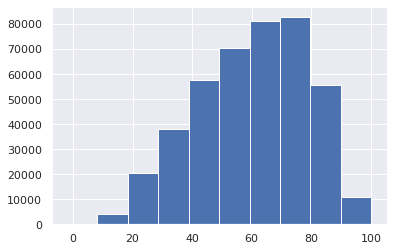

In [42]:
train_detail['Temperature'].hist()

The same with the temperature, so we do not remove any rows and proceed. The data is right skeweed.

In [43]:
threshold = 0.92
corr_matrix = train_detail.corr().abs()
corr_matrix.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Size,Week,Year
Store,1.000000,0.024004,0.085195,0.000490,0.050097,0.211088,0.208552,0.182881,0.001031,0.002997
Dept,0.024004,1.000000,0.148032,0.000601,0.004437,0.007477,0.007837,0.002966,0.000882,0.003738
Weekly_Sales,0.085195,0.148032,1.000000,0.015168,0.002312,0.020921,0.025864,0.243828,0.027673,0.010111
IsHoliday,0.000490,0.000601,0.015168,1.000000,0.155189,0.002056,0.010094,0.000526,0.054338,0.047117
Temperature,0.050097,0.004437,0.002312,0.155189,1.000000,0.182112,0.096730,0.058313,0.236276,0.065814


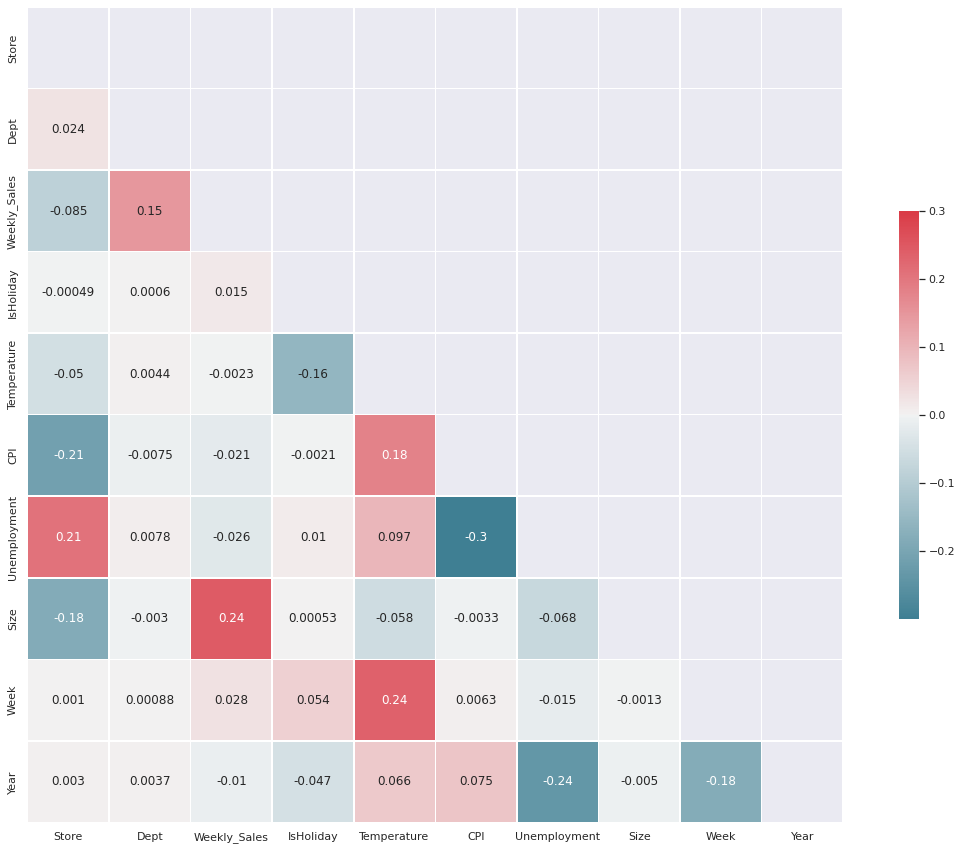

In [44]:
corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

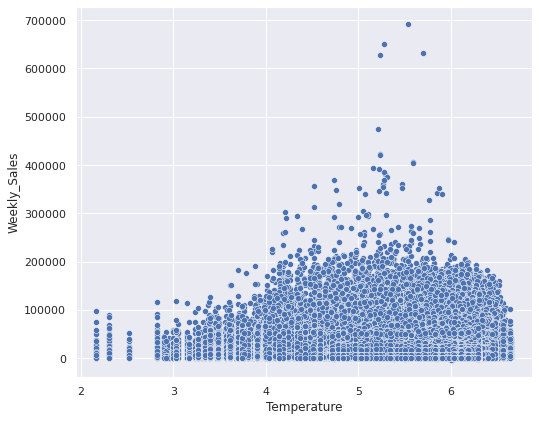

In [45]:
def mplot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    
    fig.savefig(feature+'.pdf')
mplot('Temperature')

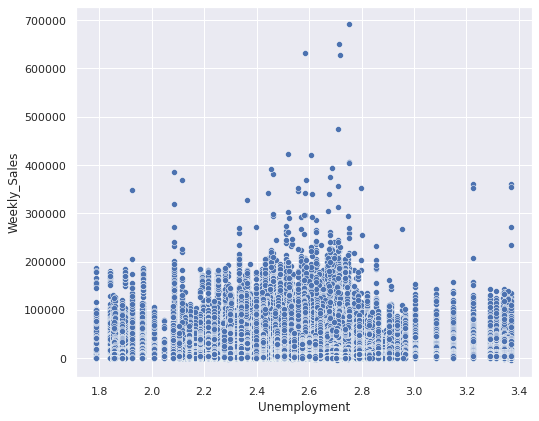

In [46]:
mplot('Unemployment')

## Label encoding IsHoliday and Type columns.

Label encoding is a process of converting lables into numeric form so that the model is able to interpret the data.

IsHoliday and Type has been label encoded as below.

In [47]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [48]:
train_detail['IsHoliday']=le.fit_transform(train_detail['IsHoliday'])
train_detail['Type']=le.fit_transform(train_detail['Type'])
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,0,42.31,211.096358,8.106,0,151315,5,2010
1,1,1,2010-02-12,46039.49,1,38.51,211.242170,8.106,0,151315,6,2010
2,1,1,2010-02-19,41595.55,0,39.93,211.289143,8.106,0,151315,7,2010
3,1,1,2010-02-26,19403.54,0,46.63,211.319643,8.106,0,151315,8,2010
4,1,1,2010-03-05,21827.90,0,46.50,211.350143,8.106,0,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,64.88,192.013558,8.684,1,118221,39,2012
421566,45,98,2012-10-05,628.10,0,64.89,192.170412,8.667,1,118221,40,2012
421567,45,98,2012-10-12,1061.02,0,54.47,192.327265,8.667,1,118221,41,2012
421568,45,98,2012-10-19,760.01,0,56.47,192.330854,8.667,1,118221,42,2012


In [49]:

train_detail.drop('Date',axis=1,inplace=True)
x_train, y_train = train_detail.drop('Weekly_Sales', axis=1), train_detail['Weekly_Sales']
#x_test, y_test = test_detail.drop('Weekly_Sales', axis=1), test_detail['Weekly_Sales']
Train_X,Test_X,Train_Y,Test_Y=train_test_split(x_train,y_train,test_size=0.33,random_state=42)

In [50]:

x_train = pd.DataFrame(data=x_train)
y_train = pd.DataFrame(data=y_train)


In [51]:
test_detail['IsHoliday']=le.fit_transform(test_detail['IsHoliday'])
test_detail['Type']=le.fit_transform(test_detail['Type'])
test_detail
# test_detail=test_detail.drop('Date',axis=1)
# test_detail=test_detail.drop('CPI',axis=1)
#test_detail=test_detail.drop('Unemployment',axis=1)
test_detail['CPI'] = test_detail['CPI'].fillna(0)
test_detail['Unemployment'] = test_detail['Unemployment'].fillna(0)
test_detail=test_detail.drop('Date',axis=1)

In [52]:
import numpy as np

x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)



In [53]:
Train_X.shape

(282451, 10)

In [54]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

# ANN Test1 

In [55]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

ANN is a feed forward neural network with certain parameters attached to each layer.

The parameters are decided based on our observations. We started by creating an ANN to check how good it performs with the parameters we passed. 

We have 7 hidden layers in the network and tried with different configurations using different activtion, kernel regularizer, kernel initializer, etc.

In [ ]:



model = Sequential([
  Dense(480, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dense(1, kernel_initializer='normal', activation='linear')
  ])


In [ ]:
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.01), 
    metrics=[msle]
)

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=64
)

Epoch 1/10
6588/6588 [==============================] - 94s 14ms/step - loss: 112127.2188 - mean_squared_logarithmic_error: 11.9720
Epoch 2/10
6588/6588 [==============================] - 89s 14ms/step - loss: 85.8689 - mean_squared_logarithmic_error: 6.2892
Epoch 3/10
6588/6588 [==============================] - 90s 14ms/step - loss: 27.6322 - mean_squared_logarithmic_error: 5.0395
Epoch 4/10
6588/6588 [==============================] - 90s 14ms/step - loss: 10.3111 - mean_squared_logarithmic_error: 4.6288
Epoch 5/10
6588/6588 [==============================] - 88s 13ms/step - loss: 11.2510 - mean_squared_logarithmic_error: 4.4702
Epoch 6/10
6588/6588 [==============================] - 88s 13ms/step - loss: 11.4703 - mean_squared_logarithmic_error: 4.4010
Epoch 7/10
6588/6588 [==============================] - 88s 13ms/step - loss: 11.3538 - mean_squared_logarithmic_error: 4.3643
Epoch 8/10
6588/6588 [==============================] - 89s 14ms/step - loss: 11.2467 - mean_squared_logar

In [ ]:
prediction=model.predict(Test_X)

In [ ]:
prediction

array([[4280.0273],
       [4280.0273],
       [4280.0273],
       ...,
       [4280.0273],
       [4280.0273],
       [4280.0273]], dtype=float32)

In [ ]:
submission_prediction=model.predict(test_detail)

In [ ]:

sample_submission['Weekly_Sales']=submission_prediction

In [ ]:

sample_submission.to_csv('submissionANN1.csv',index=False)

# from google.colab import files
# files.download('submissionANN1.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import math

In [ ]:

print(mean_squared_error(Test_Y, prediction))
print(math.sqrt(mean_squared_error(Test_Y, prediction)))

657227767.7305088
25636.453883688922


In [ ]:
history.history['mean_squared_logarithmic_error']

[11.972027778625488,
 6.2892374992370605,
 5.039495944976807,
 4.628755569458008,
 4.470151424407959,
 4.401021957397461,
 4.364285945892334,
 4.344742774963379,
 4.332975387573242,
 4.326330661773682]

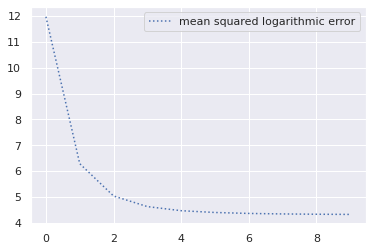

In [ ]:
plt.plot(history.history['mean_squared_logarithmic_error'], linestyle = 'dotted',label='mean squared logarithmic error')

plt.legend(loc='top right')
plt.savefig("ann1.pdf")

In [ ]:
# from google.colab import files
# files.download('ann1.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANN Test2

In [ ]:

model2 = Sequential([
  Dense(480, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  
  Dense(160, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [ ]:
msle = MeanSquaredLogarithmicError()
model2.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.01), 
    metrics=[msle]
)

In [ ]:
history = model2.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=64
)

Epoch 1/10
6588/6588 [==============================] - 118s 18ms/step - loss: 76779.7969 - mean_squared_logarithmic_error: 10.5947
Epoch 2/10
6588/6588 [==============================] - 92s 14ms/step - loss: 15.1971 - mean_squared_logarithmic_error: 5.7406
Epoch 3/10
6588/6588 [==============================] - 88s 13ms/step - loss: 8.2260 - mean_squared_logarithmic_error: 4.7712
Epoch 4/10
6588/6588 [==============================] - 90s 14ms/step - loss: 5.1407 - mean_squared_logarithmic_error: 4.4768
Epoch 5/10
6588/6588 [==============================] - 88s 13ms/step - loss: 4.6568 - mean_squared_logarithmic_error: 4.3836
Epoch 6/10
6588/6588 [==============================] - 89s 14ms/step - loss: 4.5466 - mean_squared_logarithmic_error: 4.3474
Epoch 7/10
6588/6588 [==============================] - 90s 14ms/step - loss: 4.4872 - mean_squared_logarithmic_error: 4.3306
Epoch 8/10
6588/6588 [==============================] - 89s 13ms/step - loss: 4.4509 - mean_squared_logarithmic

In [ ]:
prediction=model2.predict(Test_X)

In [ ]:
print(mean_squared_error(Test_Y, prediction))
print(math.sqrt(mean_squared_error(Test_Y, prediction)))

653266308.1767855
25559.074869345044


In [ ]:
submission_prediction=model2.predict(test_detail)
sample_submission['Weekly_Sales']=submission_prediction
sample_submission.to_csv('submissionANN2.csv',index=False)

# from google.colab import files
# files.download('submissionANN2.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANN Test3

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


In [ ]:

model3 = Sequential([
  Dense(480, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(128, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  Dense(64, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dropout(0.2),
  
  Dense(32, kernel_initializer='normal', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)),
  Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [ ]:
msle = MeanSquaredLogarithmicError()
model3.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=0.01), 
    metrics=[msle]
)

In [ ]:

history = model3.fit(
    x_train, 
    y_train, 
    epochs=10,
    batch_size=64
)

Epoch 1/10
6588/6588 [==============================] - 84s 12ms/step - loss: 78013.2578 - mean_squared_logarithmic_error: 17.3823
Epoch 2/10
6588/6588 [==============================] - 83s 13ms/step - loss: 18.3520 - mean_squared_logarithmic_error: 7.8956
Epoch 3/10
6588/6588 [==============================] - 83s 13ms/step - loss: 10.8967 - mean_squared_logarithmic_error: 6.1644
Epoch 4/10
6588/6588 [==============================] - 82s 12ms/step - loss: 6.7628 - mean_squared_logarithmic_error: 5.4075
Epoch 5/10
6588/6588 [==============================] - 81s 12ms/step - loss: 5.8030 - mean_squared_logarithmic_error: 5.0206
Epoch 6/10
6588/6588 [==============================] - 80s 12ms/step - loss: 5.4288 - mean_squared_logarithmic_error: 4.7906
Epoch 7/10
6588/6588 [==============================] - 79s 12ms/step - loss: 5.1810 - mean_squared_logarithmic_error: 4.6500
Epoch 8/10
6588/6588 [==============================] - 82s 12ms/step - loss: 5.0065 - mean_squared_logarithmic

In [ ]:
prediction=model3.predict(Test_X)

In [ ]:
print(mean_squared_error(Test_Y, prediction))
print(math.sqrt(mean_squared_error(Test_Y, prediction)))

678189254.5628195
26042.06701786207


In [ ]:
submission_prediction=model3.predict(test_detail)
sample_submission['Weekly_Sales']=submission_prediction
sample_submission.to_csv('submissionANN3.csv',index=False)

# from google.colab import files
# files.download('submissionANN3.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANN Test4

In [ ]:

model4 = Sequential([
  Dense(480, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(128, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(64, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  
  Dense(32, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),

  Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [ ]:
msle = MeanSquaredLogarithmicError()
model4.compile(
    loss=msle, 
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), 
    metrics=[msle]
)

In [ ]:

history = model4.fit(
    x_train, 
    y_train, 
    epochs=10,
    batch_size=64
)

Epoch 1/10
6588/6588 [==============================] - 74s 11ms/step - loss: 3.9796 - mean_squared_logarithmic_error: 3.9792
Epoch 2/10
6588/6588 [==============================] - 76s 12ms/step - loss: 3.9214 - mean_squared_logarithmic_error: 3.9213
Epoch 3/10
6588/6588 [==============================] - 74s 11ms/step - loss: 3.8808 - mean_squared_logarithmic_error: 3.8810
Epoch 4/10
6588/6588 [==============================] - 74s 11ms/step - loss: 3.8709 - mean_squared_logarithmic_error: 3.8708
Epoch 5/10
6588/6588 [==============================] - 74s 11ms/step - loss: 3.8651 - mean_squared_logarithmic_error: 3.8655
Epoch 6/10
6588/6588 [==============================] - 76s 11ms/step - loss: 3.9237 - mean_squared_logarithmic_error: 3.9234
Epoch 7/10
6588/6588 [==============================] - 73s 11ms/step - loss: 3.8746 - mean_squared_logarithmic_error: 3.8741
Epoch 8/10
6588/6588 [==============================] - 73s 11ms/step - loss: 3.7486 - mean_squared_logarithmic_error:

In [ ]:
prediction=model4.predict(Test_X)

In [ ]:
print(mean_squared_error(Test_Y, prediction))
print(math.sqrt(mean_squared_error(Test_Y, prediction)))

679568053.9166139
26068.526117074856


In [ ]:
submission_prediction=model4.predict(test_detail)
sample_submission['Weekly_Sales']=submission_prediction
sample_submission.to_csv('submissionANN4.csv',index=False)

# from google.colab import files
# files.download('submissionANN4.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# ANN Test5

In [ ]:

model5 = Sequential([
  Dense(480, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(128, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(64, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  
  Dense(32, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),

  Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [ ]:
#msle = MeanSquaredLogarithmicError()
model5.compile(
    loss=root_mean_squared_error, 
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.01), 
    metrics=[root_mean_squared_error]
)

In [ ]:

history = model5.fit(
    x_train, 
    y_train, 
    epochs=10,
    batch_size=64
)

Epoch 1/10
6588/6588 [==============================] - 75s 11ms/step - loss: 22059.4238 - root_mean_squared_error: 22056.8613
Epoch 2/10
6588/6588 [==============================] - 73s 11ms/step - loss: 21836.8457 - root_mean_squared_error: 21837.0156
Epoch 3/10
6588/6588 [==============================] - 74s 11ms/step - loss: 22136.3145 - root_mean_squared_error: 22135.0508
Epoch 4/10
6588/6588 [==============================] - 75s 11ms/step - loss: 22294.9922 - root_mean_squared_error: 22297.0176
Epoch 5/10
6588/6588 [==============================] - 74s 11ms/step - loss: 22261.2676 - root_mean_squared_error: 22264.1387
Epoch 6/10
6588/6588 [==============================] - 74s 11ms/step - loss: 22239.2480 - root_mean_squared_error: 22236.5449
Epoch 7/10
6588/6588 [==============================] - 73s 11ms/step - loss: 22214.1348 - root_mean_squared_error: 22213.5527
Epoch 8/10
6588/6588 [==============================] - 75s 11ms/step - loss: 22207.9512 - root_mean_squared_er

In [ ]:
submission_prediction=model5.predict(test_detail)
sample_submission['Weekly_Sales']=submission_prediction
sample_submission.to_csv('submissionANN5.csv',index=False)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from google.colab import files
# files.download('randomAct.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest Regressor

In [ ]:
train_detail.head()
#train_detail=train_detail.drop('Date',axis=1)
train_detail.drop('CPI',axis=1,inplace=True)

In [ ]:
train_detail.drop('Unemployment',axis=1,inplace=True)


The fundamental concept here is that each decision tree in
the forest will make different sorts of errors, and many of them
will cancel out when they are averaged. The ”wisdom of the
crowd” is another name for this concept.
Hypertuning the parameters can be easy with grid search
cv, but owing to huge data it takes a lot of time to actually.
So instead tested the model with different parameters and the
best results have been observed for the following parameters,


In [109]:

    
x_train, y_train = train_detail.drop('Weekly_Sales', axis=1), train_detail['Weekly_Sales']
#x_test, y_test = test_detail.drop('Weekly_Sales', axis=1), test_detail['Weekly_Sales']
Train_X,Test_X,Train_Y,Test_Y=train_test_split(x_train,y_train,test_size=0.33,random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

## Base model

In [105]:
rf = RandomForestRegressor(n_estimators=50, max_depth=25)
# params = {"max_depth":[40,50,80,100],'max_features':['auto', 'sqrt', 'log2'],'bootstrap':[True,False]}
# random = RandomizedSearchCV(rf,params,random_state=0)

# search=random.fit(x_train.head(10000),y_train.head(10000))

In [106]:
x_train

array([[1.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.51315e+05,
        5.00000e+00, 2.01000e+03],
       [1.00000e+00, 1.00000e+00, 1.00000e+00, ..., 1.51315e+05,
        6.00000e+00, 2.01000e+03],
       [1.00000e+00, 1.00000e+00, 0.00000e+00, ..., 1.51315e+05,
        7.00000e+00, 2.01000e+03],
       ...,
       [4.50000e+01, 9.80000e+01, 0.00000e+00, ..., 1.18221e+05,
        4.10000e+01, 2.01200e+03],
       [4.50000e+01, 9.80000e+01, 0.00000e+00, ..., 1.18221e+05,
        4.20000e+01, 2.01200e+03],
       [4.50000e+01, 9.80000e+01, 0.00000e+00, ..., 1.18221e+05,
        4.30000e+01, 2.01200e+03]], dtype=float32)

In [107]:
rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=25, n_estimators=50)

In [110]:
predict=rf.predict(Test_X)

In [111]:
WMAE(Test_X, Test_Y, predict)

622.83

In [112]:
predict

array([50122.28507813,  3112.05008301, 10282.76202965, ...,
       31057.4735599 ,  5833.65774035,  7791.20817593])

In [113]:
tesd_df=pd.DataFrame(Test_Y)

In [114]:
tesd_df.reset_index(drop=True, inplace=True)

In [115]:
predictionRand=pd.DataFrame(predict)

In [118]:
df_tests=tesd_df.copy()
df_tests['Random Forest']=predictionRand
df_tests

,Weekly_Sales,Random Forest
0,50932.42,50122.285078
1,3196.12,3112.050083
2,10125.03,10282.762030
3,3311.26,3606.468209
4,6335.65,5954.222804
...,...,...
139114,8986.38,9058.370649
139115,3908.10,3885.806953
139116,30327.61,31057.473560
139117,6554.60,5833.657740


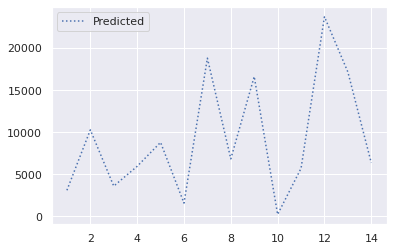

In [119]:
plt.plot(predictionRand[1:15], linestyle = 'dotted',label='Predicted')
plt.legend(loc='top right')
plt.savefig('randomPred.pdf')

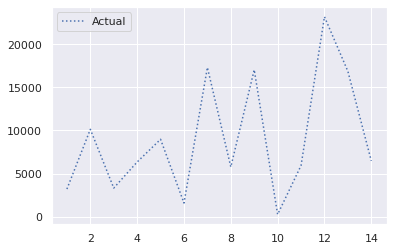

In [ ]:
plt.plot(tesd_df[1:15], linestyle = 'dotted',label='Actual')

plt.legend(loc='top right')
plt.savefig('randomAct.pdf')


In [ ]:

print(math.sqrt(mean_squared_error(Test_Y, predict)))

1395.3237095012946


## Tuning the model

In [ ]:
# def train(n_estimator,depth):
#   rf = RandomForestRegressor()
#   rf.fit(x_train,y_train)  
#   predict=rf.predict(Test_X)
#   print(n_estimator,depth)
#   print(math.sqrt(mean_squared_error(Test_Y, predict)))
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

rf = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=4, min_samples_leaf=1)
rf.fit(x_train,y_train)  


RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=4,
                      n_estimators=58)

In [ ]:
predict=rf.predict(Test_X)

In [ ]:
WMAE(Test_X, Test_Y, predict)

738.63

In [ ]:
print(math.sqrt(mean_squared_error(Test_Y, predict)))

1684.8761383382284


In [ ]:
test_score = rf.score(Test_X, Test_Y)*100

In [ ]:
print(test_score)

99.4545077907126


In [ ]:
test_detaild=test_detail.drop('CPI',axis=1);
test_detaild=test_detaild.drop('Unemployment',axis=1);


In [ ]:
test_predict=rf.predict(test_detaild)

In [ ]:
sample_submission['Weekly_Sales'] = test_predict

In [ ]:
sample_submission.to_csv('submissionRandom.csv',index=False)

In [ ]:
from google.colab import files
files.download('submissionRandom.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train,y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
test_preds = dt.predict(Test_X)
test_score = dt.score(Test_X, Test_Y)*100

In [ ]:
print(test_score)

100.0


In [ ]:
tesd_df=pd.DataFrame(Test_Y)

In [ ]:
tesd_df.reset_index(drop=True, inplace=True)

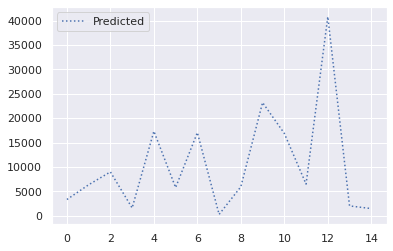

In [ ]:
plt.plot(test_preds[3:18], linestyle = 'dotted',label='Predicted')
plt.legend(loc='top right')
plt.savefig('DPred.pdf')

In [ ]:
# plt.plot(tesd_df[3:18], linestyle = 'dotted',label='Actual')
# plt.legend(loc='top right')
# plt.savefig('DAct.pdf')

In [ ]:
test_detaild=test_detail.drop('CPI',axis=1);
test_detaild=test_detaild.drop('Unemployment',axis=1);


In [ ]:
submit_predict=dt.predict(test_detaild)


In [ ]:
WMAE(Test_X, Test_Y, test_preds)

0.0

In [ ]:
submit_predict

array([39886.06, 18689.54, 19050.66, ...,   845.3 ,   695.21,   690.52])

In [ ]:
sample_submission['Weekly_Sales'] = submit_predict

In [ ]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,39886.06
1,1_1_2012-11-09,18689.54
2,1_1_2012-11-16,19050.66
3,1_1_2012-11-23,20911.25
4,1_1_2012-11-30,50943.18


In [ ]:
sample_submission.to_csv('submission.csv',index=False)

In [ ]:
# from google.colab import files
# files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Light GBM

In [66]:
import lightgbm as lgb

Light GBM is
a gradient boosting framework based on the decision tree
technique that may be used for ranking, classification, and
a variety of other machine learning applications.

In [ ]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2', 'l1'},
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

In [ ]:
# # create dataset for lightgbm
# lgb_train = lgb.Dataset(Train_X, Train_Y)
# lgb_eval = lgb.Dataset(Test_X, Test_Y, reference=lgb_train)

In [68]:
model = lgb.LGBMRegressor(n_estimators=2000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=10,
        num_leaves=50,
        min_child_weight=300)

In [70]:
model.fit(Train_X, Train_Y, eval_set=[(Train_X,Train_Y),(Test_X,Test_Y)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 6.27437e+07	training's rmse: 7921.09	valid_1's l2: 6.69663e+07	valid_1's rmse: 8183.29
[40]	training's l2: 4.65092e+07	training's rmse: 6819.76	valid_1's l2: 5.01518e+07	valid_1's rmse: 7081.79
[60]	training's l2: 3.91253e+07	training's rmse: 6255.02	valid_1's l2: 4.26277e+07	valid_1's rmse: 6528.99
[80]	training's l2: 3.55539e+07	training's rmse: 5962.71	valid_1's l2: 3.89894e+07	valid_1's rmse: 6244.15
[100]	training's l2: 3.24405e+07	training's rmse: 5695.65	valid_1's l2: 3.57754e+07	valid_1's rmse: 5981.26
[120]	training's l2: 3.00042e+07	training's rmse: 5477.61	valid_1's l2: 3.34147e+07	valid_1's rmse: 5780.54
[140]	training's l2: 2.78187e+07	training's rmse: 5274.34	valid_1's l2: 3.12173e+07	valid_1's rmse: 5587.25
[160]	training's l2: 2.61518e+07	training's rmse: 5113.88	valid_1's l2: 2.94977e+07	valid_1's rmse: 5431.18
[180]	training's l2: 2.43602e+07	training's rmse: 4935.61	valid_1's l2: 2.7764

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=10,
              min_child_weight=300, n_estimators=2000, num_leaves=50,
              subsample=0.8)

In [71]:
y_pred=model.predict(Test_X)

In [72]:
rmse_test_lightGBM = mean_squared_error(Test_Y, y_pred) ** 0.5

In [73]:
rmse_test_lightGBM

3685.5917894919744

In [74]:
importance_df = pd.DataFrame({
    'feature': Train_X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

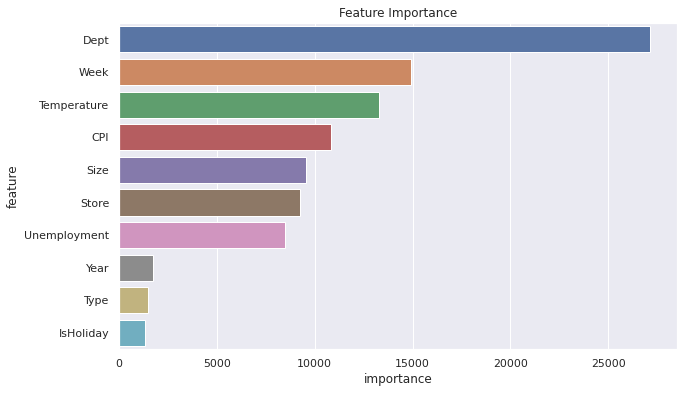

In [75]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');
plt.savefig('fetureImpLightGBM.pdf')

In [76]:
# from google.colab import files
# files.download('fetureImpLightGBM.pdf') 

## Removing some features

In [77]:
X = train_detail.drop(['Store','Dept','IsHoliday','Size','Week','Type','Year'],axis=1)


In [78]:
y = train_detail['Weekly_Sales']

In [79]:
Train_X,Test_X,Train_Y,Test_Y = train_test_split(X,y,test_size=.3,random_state=34)

In [80]:
model.fit(Train_X, Train_Y, eval_set=[(Train_X,Train_Y),(Test_X,Test_Y)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 7.77087e+06	training's rmse: 2787.63	valid_1's l2: 6.96181e+06	valid_1's rmse: 2638.52
[40]	training's l2: 7.17291e+06	training's rmse: 2678.23	valid_1's l2: 6.47229e+06	valid_1's rmse: 2544.07
[60]	training's l2: 6.97545e+06	training's rmse: 2641.11	valid_1's l2: 6.42382e+06	valid_1's rmse: 2534.53
[80]	training's l2: 6.8052e+06	training's rmse: 2608.68	valid_1's l2: 6.39695e+06	valid_1's rmse: 2529.22
[100]	training's l2: 6.67352e+06	training's rmse: 2583.32	valid_1's l2: 6.3684e+06	valid_1's rmse: 2523.57
[120]	training's l2: 6.56497e+06	training's rmse: 2562.22	valid_1's l2: 6.31341e+06	valid_1's rmse: 2512.65
[140]	training's l2: 6.47147e+06	training's rmse: 2543.91	valid_1's l2: 6.28506e+06	valid_1's rmse: 2507
[160]	training's l2: 6.32924e+06	training's rmse: 2515.8	valid_1's l2: 6.25711e+06	valid_1's rmse: 2501.42
[180]	training's l2: 6.24963e+06	training's rmse: 2499.93	valid_1's l2: 6.24411e+06	

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=10,
              min_child_weight=300, n_estimators=2000, num_leaves=50,
              subsample=0.8)

In [83]:
pred=model.predict(Test_X)


In [84]:
rmse_test_lightGBM2 = mean_squared_error(Test_Y, pred) ** 0.5
rmse_test_lightGBM2

2491.7346775548594

In [85]:
print(math.sqrt(mean_squared_error(Test_Y, pred)))

2491.7346775548594


In [95]:
actual_test=pd.DataFrame(Test_Y)
actual_test.reset_index(drop=True,inplace=True)

In [98]:
df_LGBM=pd.DataFrame(pred)
df_tests=actual_test.copy()
df_tests['lgbm']=df_LGBM

In [99]:
df_tests

,Weekly_Sales,lgbm
0,77.00,108.939278
1,39130.18,38963.735520
2,19517.05,19595.817233
3,43011.76,42870.985127
4,3843.52,3897.504588
...,...,...
126466,4884.97,4979.708533
126467,12448.17,12320.527380
126468,5969.84,5861.584962
126469,21228.21,21698.679017


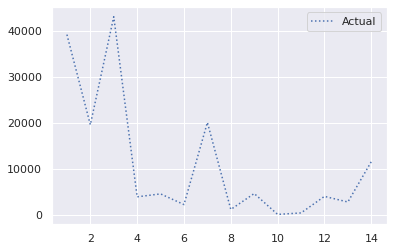

In [101]:
plt.plot(actual_test[1:15], linestyle = 'dotted',label='Actual')
plt.legend(loc='top right')
plt.savefig('LGBMAct.pdf')

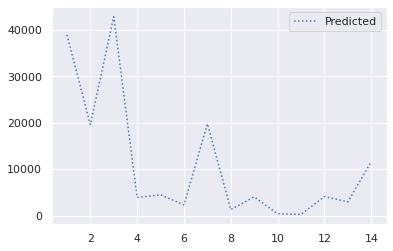

In [102]:
plt.plot(df_LGBM[1:15], linestyle = 'dotted',label='Predicted')
plt.legend(loc='top right')
plt.savefig('LGBMPred.pdf')

In [104]:
# from google.colab import files
# files.download('LGBMAct.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

The memory space is so
small in RNN, the RNN problem is concatenated with it,
resulting in a vanishing gradient problem. And then there’s
LSTM. The acronym LSTM stands for Long Short Term

A pivot table is created for time series data as below. 

In [ ]:
train_detail_rnn.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010


In [ ]:
df_rnn = train_detail_rnn[['Date', 'Store', 'Dept', 'Weekly_Sales']]
df_rnn['Date'] = pd.to_datetime(df_rnn['Date'], format = '%Y-%m-%d')
df_rnn['Date'].freq = 'W-FRI'
df_rnn['Store_Dept_code'] = df_rnn.apply(lambda x: str(x['Store']) + '-' + str(x['Dept']), axis = 1)
df_rnn.head(2)

,Date,Store,Dept,Weekly_Sales,Store_Dept_code
0,2010-02-05,1,1,24924.50,1-1
1,2010-02-12,1,1,46039.49,1-1


In [ ]:
df_rnn_piv = df_rnn.pivot_table(index = 'Date', columns = 'Store_Dept_code', values = 'Weekly_Sales')
df_rnn_piv =df_rnn_piv.fillna(0)
df_rnn_piv.head(2)

Store_Dept_code,1-1,1-10,1-11,1-12,1-13,1-14,1-16,1-17,1-18,1-19,...,9-9,9-90,9-91,9-92,9-93,9-94,9-95,9-96,9-97,9-98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,30721.50,24213.18,8449.54,41969.29,19466.91,10217.55,13223.76,4729.5,1947.05,...,7245.32,2335.92,292.64,11620.09,0.0,0.0,23292.10,2438.08,668.48,0.0
2010-02-12,46039.49,31494.77,21760.75,8654.07,36476.40,18129.02,11873.89,13403.66,19006.5,1490.79,...,6556.94,2486.18,544.74,11080.50,0.0,982.5,22317.38,2304.09,766.93,0.0


## Finding the threshold Date for the forecast

In [ ]:
threshold_date = pd.to_datetime(train_detail_rnn.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')
#threshold_date = df_rnn[df_rnn.Date>'2012-01-01']['Date'].iloc[0].strftime('%Y-%m-%d')
threshold_date

'2012-02-03'

In [ ]:
train_rnn = df_rnn_piv[df_rnn_piv.index<threshold_date]
test_rnn = df_rnn_piv[df_rnn_piv.index>=threshold_date]

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(train_rnn)
X_train_sc = mms.transform(train_rnn)
X_test_sc = mms.transform(test_rnn)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length  = 48
batch_size = 10 
generator = TimeseriesGenerator(X_train_sc, X_train_sc, length=length, batch_size=batch_size)

In [ ]:
import timeit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM
from keras import layers

In [ ]:
test_index = df_rnn_piv[df_rnn_piv.index>=threshold_date].index
main_rnn_pred_df = pd.DataFrame(index = test_index)

threshold_date = pd.to_datetime(train_detail_rnn.Date.unique()[-test.Date.nunique()]).strftime('%Y-%m-%d')
threshold_date





'2012-02-03'

In [ ]:
sample_size = 150
whole_range = df_rnn_piv.shape[1]

samp = 0
end = sample_size
start = 0

In [ ]:
if (round(whole_range/sample_size)*sample_size)<whole_range:
    extra = 1
else:
    extra = 0

In [ ]:
samples = round(whole_range/sample_size)+extra


## Modeling

In [ ]:
while samp<samples:
    start_time = timeit.default_timer()
    print(f"Working on Sample: [{start}:{end}]")
    train_rnn = df_rnn_piv[df_rnn_piv.index<threshold_date].iloc[:,start:end]
    test_rnn = df_rnn_piv[df_rnn_piv.index>=threshold_date].iloc[:,start:end]
    samp = samp+1
    start= start+sample_size
    end = end+sample_size
    mms = MinMaxScaler()
    mms.fit(train_rnn)
    X_train_sc = mms.transform(train_rnn)
    X_test_sc = mms.transform(test_rnn)
    length  = 48
    batch_size = 20 
    generator = TimeseriesGenerator(X_train_sc, X_train_sc, length=length, batch_size=batch_size) #Timesteps
    model = Sequential()
    model.add(LSTM(128,activation= 'tanh',return_sequences=True, input_shape=(length,X_train_sc.shape[1])))
    model.add(LSTM(64, activation='tanh', return_sequences = False))
    model.add(Dense(X_train_sc.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    validation_generator = TimeseriesGenerator(X_test_sc,X_test_sc, length=38, batch_size=batch_size)
    model.fit(generator,epochs=160,
                        validation_data=validation_generator, verbose=2)
    n_features = X_train_sc.shape[1]
    test_predictions = []
    first_eval_batch = X_train_sc[:length]
    current_batch = first_eval_batch.reshape((1, length, n_features))

    for i in range(len(test_rnn)):
    
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    inv_test_pred = mms.inverse_transform(test_predictions)
    pred_df = pd.DataFrame (data = inv_test_pred, columns =test_rnn.columns, index = test_rnn.index )
    
    main_rnn_pred_df = pd.merge(main_rnn_pred_df,pred_df, right_index=True, left_index=True)
    
    stop_time = timeit.default_timer()
    execution_time = stop_time - start_time
    
    print('Samples Done:', samp )
    print('Samples left:', samples- (samp) )
    print("Sample Prediction time is "+str(round(execution_time))+" seconds")




Streaming output truncated to the last 5000 lines.
3/3 - 0s - loss: 0.0100 - val_loss: 0.0223 - 291ms/epoch - 97ms/step
Epoch 93/160
3/3 - 0s - loss: 0.0099 - val_loss: 0.0224 - 287ms/epoch - 96ms/step
Epoch 94/160
3/3 - 0s - loss: 0.0098 - val_loss: 0.0225 - 301ms/epoch - 100ms/step
Epoch 95/160
3/3 - 0s - loss: 0.0097 - val_loss: 0.0222 - 291ms/epoch - 97ms/step
Epoch 96/160
3/3 - 0s - loss: 0.0096 - val_loss: 0.0224 - 291ms/epoch - 97ms/step
Epoch 97/160
3/3 - 0s - loss: 0.0096 - val_loss: 0.0224 - 304ms/epoch - 101ms/step
Epoch 98/160
3/3 - 0s - loss: 0.0095 - val_loss: 0.0221 - 285ms/epoch - 95ms/step
Epoch 99/160
3/3 - 0s - loss: 0.0095 - val_loss: 0.0221 - 294ms/epoch - 98ms/step
Epoch 100/160
3/3 - 0s - loss: 0.0095 - val_loss: 0.0230 - 285ms/epoch - 95ms/step
Epoch 101/160
3/3 - 0s - loss: 0.0095 - val_loss: 0.0220 - 293ms/epoch - 98ms/step
Epoch 102/160
3/3 - 0s - loss: 0.0093 - val_loss: 0.0220 - 302ms/epoch - 101ms/step
Epoch 103/160
3/3 - 0s - loss: 0.0093 - val_loss: 0.02

In [ ]:
rnn_pred_trans = main_rnn_pred_df.stack().reset_index()
rnn_pred_trans.columns = ['Date', 'Store_Dept_code', 'Weekly_Sales_Rnn']
df_with_pred = pd.merge(df_rnn,rnn_pred_trans, right_on = ['Date', 'Store_Dept_code'], left_on=['Date', 'Store_Dept_code'], how = 'left')

In [ ]:
from sklearn import metrics
from sklearn.metrics import  r2_score
actual = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()].Weekly_Sales
predicted = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()].Weekly_Sales_Rnn




print(round(np.sqrt(metrics.mean_squared_error(actual, predicted))))


4932


In [65]:
# s1.head()

In [ ]:
df_temp = df_with_pred[~df_with_pred.Weekly_Sales_Rnn.isnull()]
df_temp =df_temp[(df_temp.Store ==1)&(df_temp.Dept == 1)]
df_temp.set_index('Date', inplace = True)

In [ ]:
df_temp.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'Store_Dept_code', 'Weekly_Sales_Rnn'], dtype='object')

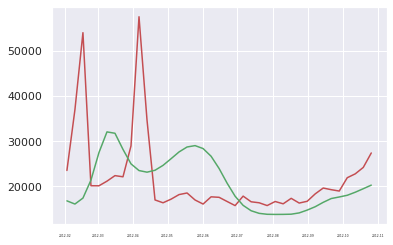

<Figure size 1152x1152 with 0 Axes>

In [ ]:
plt.plot(df_temp['Weekly_Sales'], color = 'r')
plt.plot(df_temp['Weekly_Sales_Rnn'], color = 'g')
plt.tick_params(axis='x', which='major', labelsize = 3)

plt.figure(figsize = (16,16))
plt.savefig('LSTMPrediction.pdf')
plt.show()




In [ ]:
from google.colab import files
files.download('XGAct.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XG Boost

Extreme Gradient
Boosting (XGBoost) is an open-source library that provides an
efficient and effective implementation of the gradient boosting
algorithm.

In [123]:
from xgboost import XGBRegressor

In [124]:
xgmodel = XGBRegressor(random_state=48, n_jobs=-1, n_estimators=20, max_depth=12)

In [125]:
xgmodel.fit(Train_X,Train_Y)

[17:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=12, n_estimators=20, n_jobs=-1, random_state=48)

In [126]:
predict=xgmodel.predict(Test_X)

In [127]:
print(math.sqrt(mean_squared_error(Test_Y, predict)))

6038.371404764031


In [128]:
WMAE(Test_X, Test_Y, predict)

3116.47

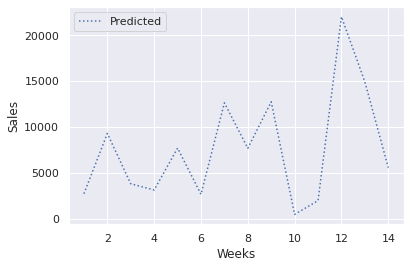

In [129]:
tesd_pred=pd.DataFrame(predict)
plt.plot(tesd_pred[1:15], linestyle = 'dotted',label='Predicted')
plt.legend(loc='top right')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.savefig('XGPred.pdf')

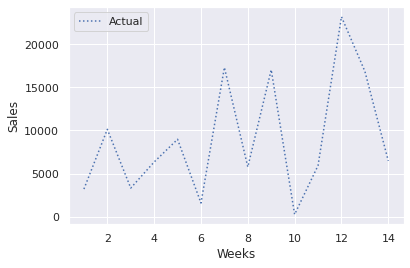

In [130]:
tesd_df=pd.DataFrame(Test_Y)
tesd_df.reset_index(drop=True, inplace=True)


plt.plot(tesd_df[1:15], linestyle = 'dotted',label='Actual')
plt.legend(loc='top right')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.savefig('XGAct.pdf')

# Comparison

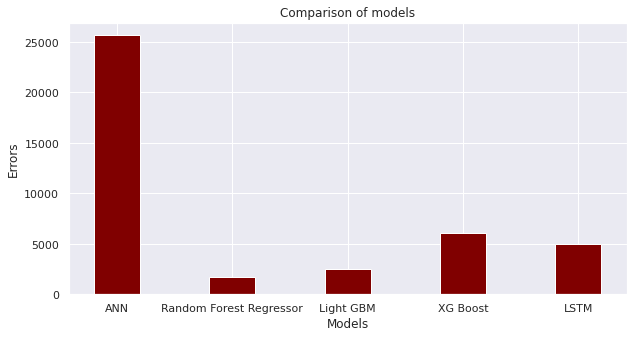

In [87]:
import matplotlib.pyplot as plt
data = {'ANN':25641.90, 'Random Forest Regressor':1684.87, 'Light GBM':2491.73,'XG Boost':6038.37,'LSTM':4992
        }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Errors")
plt.title("Comparison of models")

plt.savefig("projectcomparison.pdf")

In [ ]:
mms.transform(train_rnn).shape

(104, 150)

In [131]:
from google.colab import files
files.download('XGPred.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>